In [1]:
# Imports necessários
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def PlotSeries(y_arrays, x_arrays=None, w=8, h=5, lw=1.5, ms=3, mrkr=None,
               title='', xname='x', yname='y', legend_labels=None,
               pltly=True, save=False, file_name='plot.png', return_fig=False):
    """
    Plota ou cria um objeto de figura com múltiplas séries de dados.
    
    Se return_fig=True, a função retorna o objeto da figura em vez de exibi-lo.
    """
    
    if x_arrays is None:
        x_arrays = [np.arange(len(y)) for y in y_arrays]
    if legend_labels is None:
        legend_labels = [f'Série {i+1}' for i in range(len(y_arrays))]

    if pltly:
        # Para Plotly, retornamos os traços (dados) e o layout (configurações) separadamente
        traces = []
        for x, y, name in zip(x_arrays, y_arrays, legend_labels):
            trace = go.Scatter(x=x, y=y, name=name, mode='lines+markers',
                               line=dict(width=lw), marker=dict(size=ms*2))
            traces.append(trace)
        
        layout = go.Layout(width=w*100, height=h*100, title=title,
                           xaxis_title=xname, yaxis_title=yname,
                           legend_title_text='Legenda')
        
        fig = go.Figure(data=traces, layout=layout)
        
        if return_fig:
            return fig # Retorna o objeto completo da figura

        fig.show()
        if save:
            try:
                fig.write_image(file_name, scale=5)
                print(f"Gráfico salvo como '{file_name}'")
            except ValueError as e:
                print(f"Erro ao salvar a imagem: {e}")
                print("Instale 'kaleido': pip install -U kaleido")
    
    else: # Matplotlib
        fig, ax = plt.subplots(figsize=(w, h))
        
        for x, y, label in zip(x_arrays, y_arrays, legend_labels):
            ax.plot(x, y, linestyle='-', linewidth=lw, marker=mrkr, markersize=ms, label=label)
            
        ax.set_xlabel(xname)
        ax.set_ylabel(yname)
        ax.set_title(title)
        ax.grid(True)
        ax.legend()
        
        if return_fig:
            return fig # Retorna a figura para composição

        if save:
            plt.savefig(file_name, dpi=300, bbox_inches='tight')
            print(f"Gráfico salvo como '{file_name}'")

        plt.show()
        plt.close(fig) # Fecha a figura para liberar memória

In [2]:
def MultiPlot(plots_data, rows, cols, pltly=True, main_title='', 
              save=False, file_name='multiplot.png', fig_size=(12, 8)):
    """
    Combina múltiplos gráficos gerados pela PlotSeries em uma única imagem.

    Args:
        plots_data (list of dict): Uma lista de dicionários, onde cada dicionário
                                   contém os argumentos para uma chamada da PlotSeries.
        rows (int): Número de linhas na grade de subplots.
        cols (int): Número de colunas na grade de subplots.
        pltly (bool, optional): Define se usará Plotly ou Matplotlib. Defaults to True.
        main_title (str, optional): Título principal para o conjunto de gráficos.
        save (bool, optional): Se True, salva a imagem final. Defaults to False.
        file_name (str, optional): Nome do arquivo para salvar.
        fig_size (tuple, optional): Tamanho total da figura (para Matplotlib).
    """
    if len(plots_data) > rows * cols:
        print(f"Aviso: Você tem {len(plots_data)} gráficos para plotar, mas a grade é de {rows}x{cols}. Alguns gráficos não serão exibidos.")

    if pltly:
        # Pega os títulos dos subplots dos dados, se existirem
        subplot_titles = [p.get('title', '') for p in plots_data]
        fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)

        for i, plot_args in enumerate(plots_data):
            if i >= rows * cols: break
            
            # Posição na grade
            row = i // cols + 1
            col = i % cols + 1
            
            # Gera a figura temporária para extrair os dados (traços)
            temp_fig = PlotSeries(pltly=True, return_fig=True, **plot_args)
            
            # Adiciona os traços da figura temporária ao subplot correto
            for trace in temp_fig.data:
                fig.add_trace(trace, row=row, col=col)
            
            # Atualiza os eixos do subplot
            fig.update_xaxes(title_text=plot_args.get('xname', 'x'), row=row, col=col)
            fig.update_yaxes(title_text=plot_args.get('yname', 'y'), row=row, col=col)

        fig.update_layout(title_text=main_title, height=fig_size[1]*100, width=fig_size[0]*100)
        fig.show()

        if save:
            fig.write_image(file_name, scale=3)
            print(f"Multi-plot salvo como '{file_name}'")

    else: # Matplotlib
        fig, axes = plt.subplots(rows, cols, figsize=fig_size)
        # Garante que 'axes' seja sempre um array iterável
        if rows * cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        for i, ax in enumerate(axes):
            if i >= len(plots_data):
                ax.axis('off') # Esconde eixos de subplots não utilizados
                continue

            plot_args = plots_data[i]
            
            # Desempacota os argumentos para o plot
            x_arrays = plot_args.get('x_arrays')
            y_arrays = plot_args.get('y_arrays')
            legend_labels = plot_args.get('legend_labels')
            
            # Lógica de criação de dados padrão (caso não sejam fornecidos)
            if y_arrays is None: continue
            if x_arrays is None:
                x_arrays = [np.arange(len(y)) for y in y_arrays]
            if legend_labels is None:
                legend_labels = [f'Série {j+1}' for j in range(len(y_arrays))]

            # Plota os dados no eixo (ax) correto
            for x, y, label in zip(x_arrays, y_arrays, legend_labels):
                ax.plot(x, y, label=label)
            
            ax.set_title(plot_args.get('title', f'Gráfico {i+1}'))
            ax.set_xlabel(plot_args.get('xname', 'x'))
            ax.set_ylabel(plot_args.get('yname', 'y'))
            ax.grid(True)
            ax.legend()
            
        fig.suptitle(main_title, fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta para o título principal caber

        if save:
            plt.savefig(file_name, dpi=300)
            print(f"Multi-plot salvo como '{file_name}'")

        plt.show()

Gráfico salvo como 'plot.png'


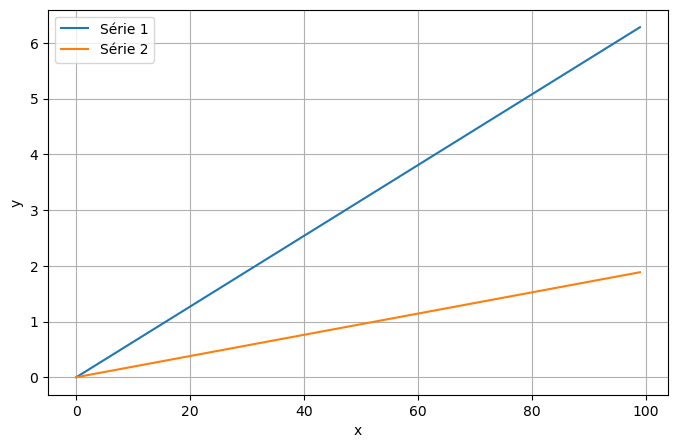

In [7]:
x_base = np.linspace(0, 2 * np.pi, 100)
PlotSeries(y_arrays=[x_base,x_base*0.3],pltly=False,save=True)

--- Gerando com Matplotlib (grade 2x2) ---


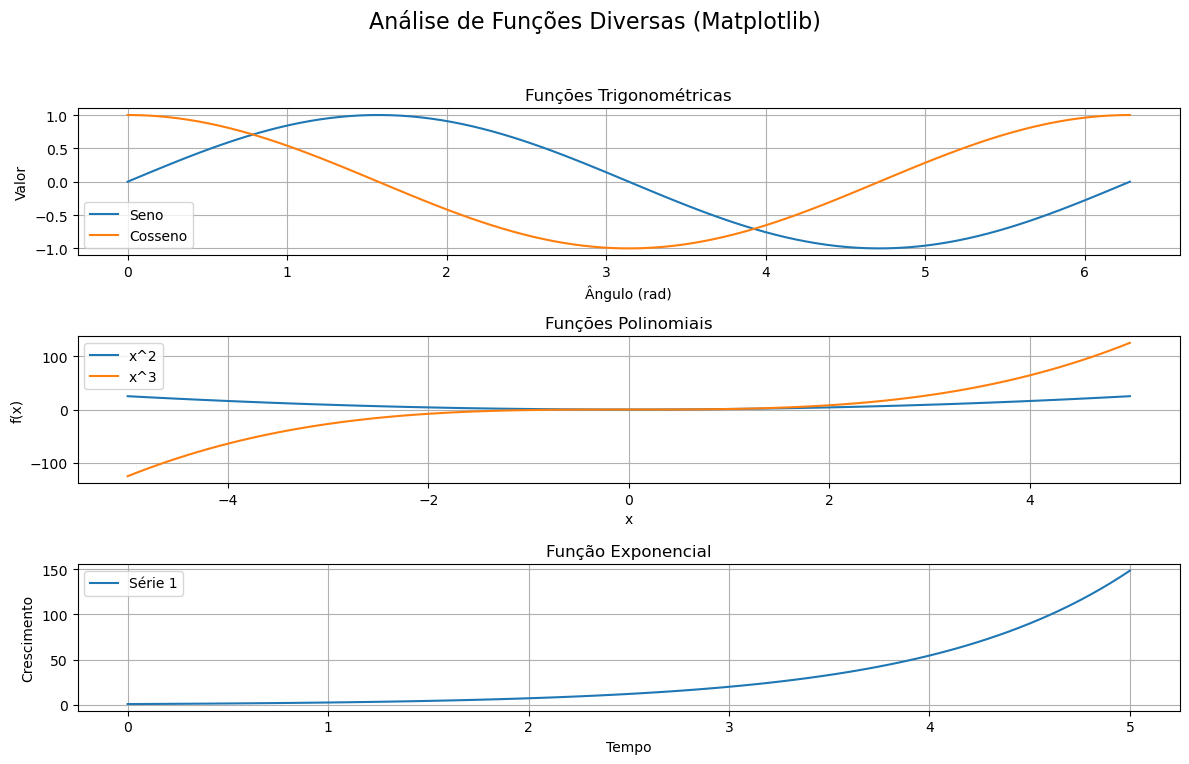


--- Gerando com Plotly (grade 1x3) ---


In [4]:
# --- Dados para o Gráfico 1 (Seno e Cosseno) ---
x_base = np.linspace(0, 2 * np.pi, 100)
plot1_args = {
    'y_arrays': [np.sin(x_base), np.cos(x_base)],
    'x_arrays': [x_base, x_base],
    'title': 'Funções Trigonométricas',
    'xname': 'Ângulo (rad)',
    'yname': 'Valor',
    'legend_labels': ['Seno', 'Cosseno']
}

# --- Dados para o Gráfico 2 (Polinômios) ---
x_poly = np.linspace(-5, 5, 100)
plot2_args = {
    'y_arrays': [x_poly**2, x_poly**3],
    'x_arrays': [x_poly, x_poly],
    'title': 'Funções Polinomiais',
    'xname': 'x',
    'yname': 'f(x)',
    'legend_labels': ['x^2', 'x^3']
}

# --- Dados para o Gráfico 3 (Exponencial) ---
x_exp = np.linspace(0, 5, 100)
plot3_args = {
    'y_arrays': [np.exp(x_exp)],
    'x_arrays': [x_exp],
    'title': 'Função Exponencial',
    'xname': 'Tempo',
    'yname': 'Crescimento'
}


# Lista de todos os plots que queremos combinar
all_plots = [plot1_args, plot2_args, plot3_args]

# --- Usando a MultiPlot ---

# Exemplo 1: Matplotlib (2x2, um ficará em branco)
print("--- Gerando com Matplotlib (grade 2x2) ---")
MultiPlot(all_plots, rows=3, cols=1, pltly=False, main_title='Análise de Funções Diversas (Matplotlib)', fig_size=(12,8))

# Exemplo 2: Plotly (1x3, lado a lado)
print("\n--- Gerando com Plotly (grade 1x3) ---")
MultiPlot(all_plots, rows=1, cols=3, pltly=True, main_title='Análise de Funções Diversas (Plotly)', fig_size=(18, 5))